# 3D OSZTALYOZAS

In [1]:
import os
import numpy as np
import keras
import trimesh
import tqdm
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from pointnet.dataset import ModelNetDataset, gen_modelnet_id
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors
import numpy as np
from torch_geometric.utils import from_scipy_sparse_matrix
from torch.utils.data import Dataset,DataLoader
from learning3d.models import DGCNN
from pointnet.model import PointNetCls
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau



In [ ]:
DATA_DIR = keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [ ]:
print(DATA_DIR)

## Feature keszites az SVM-hez, RF-hez

In [4]:
def bounding_box_dimension(mesh):
    return mesh.bounding_box.extents
def surface_area(mesh):
    return mesh.area
def volume(mesh):
    return mesh.volume
def compactness(mesh):
    return mesh.volume**2 / mesh.area**3
def eccentricity(mesh):
    eigenvalues = np.linalg.eigvalsh(np.cov(mesh.vertices.T))
    return np.sqrt(eigenvalues[-1] / eigenvalues[0])
def genus(mesh):
    return mesh.euler_number // 2
def euler_characteristic(mesh):
    return len(mesh.vertices) - len(mesh.edges) + len(mesh.faces)
def num_connected_components(mesh):
    return len(mesh.split())

In [5]:
d_path = "C:/Users/daneb/.keras/datasets/modelnet_extracted/ModelNet10"

In [6]:
def extract_features(mesh):
    features = []
    features.extend(bounding_box_dimension(mesh))
    features.append(surface_area(mesh))
    features.append(volume(mesh))
    features.append(compactness(mesh))
    features.append(eccentricity(mesh))
    features.append(genus(mesh))
    features.append(euler_characteristic(mesh))
    features.append(num_connected_components(mesh))
    return features

output_csv = "modelnet10_features.csv"
with open(output_csv, 'w') as f:
    f.write("label,bbd_x,bbd_y,bbd_z,s_area,volume,compact,eccent,genus,euler,num_conn\n")

for class_name in tqdm.tqdm([d for d in os.listdir(d_path) if os.path.isdir(os.path.join(d_path, d))], desc="Classes"):
    class_path = os.path.join(d_path, class_name)
    if not os.path.isdir(class_path):
        continue  
    for split in ['train']:
        split_path = os.path.join(class_path, split)
        mesh_files = [file for file in os.listdir(split_path) if file.endswith(('.off'))]
        for file in tqdm.tqdm(mesh_files, desc=f"{class_name}/{split}", leave=False):
            mesh_path = os.path.join(split_path, file)
            mesh = trimesh.load(mesh_path)
            features = extract_features(mesh)
            with open(output_csv, 'a') as f:
                f.write(f"{class_name},{','.join(map(str, features))}\n")


Classes:   0%|          | 0/10 [00:00<?, ?it/s]

Classes: 100%|██████████| 10/10 [05:03<00:00, 30.33s/it]


In [6]:
mesh_features_df = pd.read_csv("modelnet10_features.csv")

In [7]:
mesh_features_df.head()

,label,bbd_x,bbd_y,bbd_z,s_area,volume,compact,eccent,genus,euler,num_conn
0,bathtub,32.256600,54.000500,40.211500,32701.112088,1.531873e+00,6.710543e-14,1.655826,794,-6078,0
1,bathtub,35.243882,59.489766,22.750000,17020.348330,-2.425319e-12,1.192978e-36,1.825356,167,-1184,0
2,bathtub,27.559100,66.929100,21.535390,12562.333554,2.142343e+04,2.315086e-04,3.291839,2038,-32221,4
3,bathtub,61.000040,61.000000,36.574800,18972.581747,3.620864e+04,1.919752e-04,2.749974,268,-5531,0
4,bathtub,31.647400,61.016600,29.846396,7520.084685,1.447286e+03,4.925390e-06,2.456193,-21,-46055,1


In [8]:
print(mesh_features_df.isnull().sum())

label       0
bbd_x       0
bbd_y       0
bbd_z       0
s_area      0
volume      0
compact     0
eccent      0
genus       0
euler       0
num_conn    0
dtype: int64


In [9]:
X = mesh_features_df.drop(columns=['label']) 
y = mesh_features_df['label']

In [10]:
print(y.value_counts())

label
chair          889
sofa           680
bed            515
monitor        465
table          392
toilet         344
desk           200
dresser        200
night_stand    200
bathtub        106
Name: count, dtype: int64


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [13]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    print(f"\nUsing {kernel} kernel")
    
    svm = make_pipeline(StandardScaler(), SVC(kernel=kernel, random_state=42))
    svm.fit(X_train, y_train)
    
    y_pred = svm.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")


Using linear kernel


c:\Users\daneb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\daneb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\daneb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

     bathtub       0.00      0.00      0.00        32
         bed       0.45      0.03      0.06       155
       chair       0.42      0.93      0.58       267
        desk       0.00      0.00      0.00        60
     dresser       0.69      0.15      0.25        60
     monitor       0.60      0.21      0.31       139
 night_stand       0.67      0.17      0.27        60
        sofa       0.37      0.84      0.51       204
       table       0.10      0.03      0.05       118
      toilet       0.30      0.03      0.05       103

    accuracy                           0.40      1198
   macro avg       0.36      0.24      0.21      1198
weighted avg       0.39      0.40      0.29      1198

Accuracy: 40.07%

Using poly kernel


c:\Users\daneb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\daneb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\daneb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

     bathtub       0.00      0.00      0.00        32
         bed       0.22      0.03      0.05       155
       chair       0.25      0.98      0.40       267
        desk       0.25      0.02      0.03        60
     dresser       0.77      0.17      0.27        60
     monitor       0.58      0.08      0.14       139
 night_stand       0.78      0.12      0.20        60
        sofa       0.26      0.11      0.15       204
       table       0.00      0.00      0.00       118
      toilet       0.00      0.00      0.00       103

    accuracy                           0.26      1198
   macro avg       0.31      0.15      0.12      1198
weighted avg       0.29      0.26      0.16      1198

Accuracy: 26.46%

Using rbf kernel


c:\Users\daneb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\daneb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\daneb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

     bathtub       0.00      0.00      0.00        32
         bed       0.48      0.08      0.14       155
       chair       0.41      0.93      0.57       267
        desk       0.00      0.00      0.00        60
     dresser       0.48      0.17      0.25        60
     monitor       0.37      0.19      0.25       139
 night_stand       0.67      0.03      0.06        60
        sofa       0.36      0.82      0.50       204
       table       0.00      0.00      0.00       118
      toilet       0.22      0.02      0.04       103

    accuracy                           0.39      1198
   macro avg       0.30      0.22      0.18      1198
weighted avg       0.33      0.39      0.28      1198

Accuracy: 39.07%

Using sigmoid kernel
              precision    recall  f1-score   support

     bathtub       0.00      0.00      0.00        32
         bed       0.16      0.13      0.14       155
       chair       0.46      0.80      

In [16]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

Classification Report:
              precision    recall  f1-score   support

     bathtub       0.57      0.38      0.45        32
         bed       0.73      0.68      0.70       155
       chair       0.88      0.93      0.91       267
        desk       0.53      0.35      0.42        60
     dresser       0.85      0.77      0.81        60
     monitor       0.78      0.79      0.79       139
 night_stand       0.73      0.72      0.72        60
        sofa       0.67      0.86      0.75       204
       table       0.73      0.64      0.68       118
      toilet       0.89      0.79      0.84       103

    accuracy                           0.77      1198
   macro avg       0.74      0.69      0.71      1198
weighted avg       0.76      0.77      0.76      1198

Accuracy: 76.63%


C:\Users\daneb\AppData\Local\Temp\ipykernel_18892\2135848846.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.array(feature_names)[indices], y=importances[indices], palette="viridis")


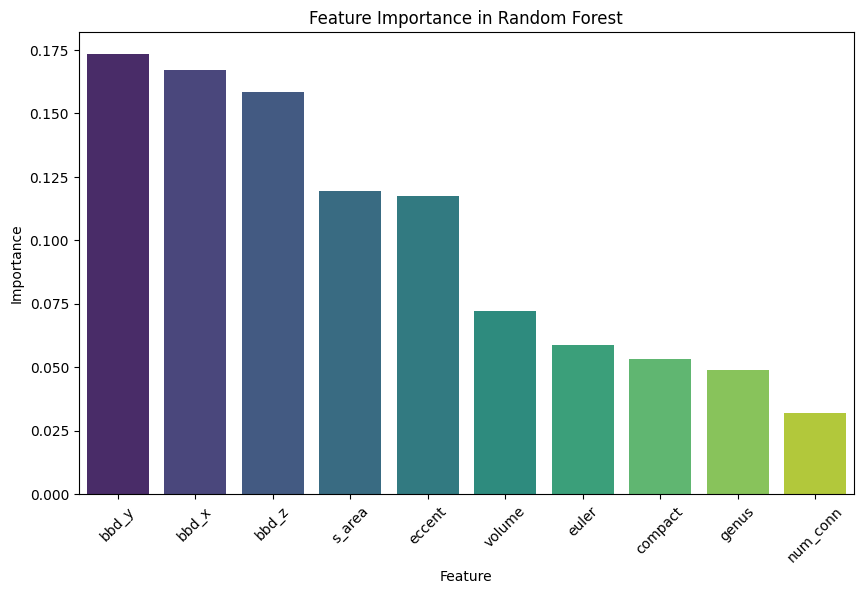

In [22]:
importances = rf.feature_importances_
feature_names = X_train.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=np.array(feature_names)[indices], y=importances[indices], palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest")
plt.show()


## PointNet
[Forras - 1](https://arxiv.org/pdf/1612.00593)
[Forras - 2](https://keras.io/examples/vision/pointnet/)
[Forras - 3](https://github.com/fxia22/pointnet.pytorch)

In [23]:
with open(os.path.join(d_path, 'train.txt'), 'w') as train_f, \
     open(os.path.join(d_path, 'test.txt'), 'w') as test_f:
    for cls in os.listdir(d_path):
        cls_path = os.path.join(d_path, cls)
        if os.path.isdir(cls_path):  
            for split in ['train', 'test']:  
                split_path = os.path.join(cls_path, split)
                if os.path.isdir(split_path):  
                    for file in os.listdir(split_path):
                        if file.endswith('.ply'):  
                            line = f"{cls}/{split}/{file}\n"
                            if split == 'train':
                                train_f.write(line)
                            else:
                                test_f.write(line)

print("Generated train.txt and test.txt successfully.")

Generated train.txt and test.txt successfully.


In [24]:
os.chdir('pointnet.pytorch')

In [25]:
d_path = "C:/Users/daneb/.keras/datasets/modelnet_extracted/ModelNet10"


In [26]:
gen_modelnet_id(d_path)

train_dataset = ModelNetDataset(root=d_path, split='train', npoints=1024, data_augmentation=True)

test_dataset = ModelNetDataset(root=d_path, split='test', npoints=1024, data_augmentation=False)


{'bathtub': 0, 'bed': 1, 'chair': 2, 'desk': 3, 'dresser': 4, 'monitor': 5, 'night_stand': 6, 'sofa': 7, 'table': 8, 'toilet': 9}
{'bathtub': 0, 'bed': 1, 'chair': 2, 'desk': 3, 'dresser': 4, 'monitor': 5, 'night_stand': 6, 'sofa': 7, 'table': 8, 'toilet': 9}


In [27]:
def convert_off_to_ply(off_path, ply_path):
    mesh = trimesh.load(off_path)
    mesh.export(ply_path)

for root, dirs, files in os.walk(d_path):
    for file in files:
        if file.endswith('.off'):
            off_file = os.path.join(root, file)
            ply_file = off_file.replace('.off', '.ply')
            convert_off_to_ply(off_file, ply_file)

In [28]:
train_dataset = ModelNetDataset(root=d_path, split='train', npoints=1024, data_augmentation=True)
test_dataset = ModelNetDataset(root=d_path, split='test', npoints=1024, data_augmentation=False)

{'bathtub': 0, 'bed': 1, 'chair': 2, 'desk': 3, 'dresser': 4, 'monitor': 5, 'night_stand': 6, 'sofa': 7, 'table': 8, 'toilet': 9}
{'bathtub': 0, 'bed': 1, 'chair': 2, 'desk': 3, 'dresser': 4, 'monitor': 5, 'night_stand': 6, 'sofa': 7, 'table': 8, 'toilet': 9}


In [29]:
batch_size = 32
npoints = 1024
epochs = 15
learning_rate = 0.0005 

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [30]:
print("Contents of ModelNet10:")
for item in os.listdir(d_path):
    print(item)

Contents of ModelNet10:
.DS_Store
bathtub
bed
chair
desk
dresser
monitor
night_stand
README.txt
sofa
table
test.txt
toilet
train.txt


Epoch [1/15], Loss: 1.3650, Accuracy: 56.15%
Test Accuracy after Epoch [1/15]: 50.99%
Epoch [2/15], Loss: 0.9715, Accuracy: 67.90%
Test Accuracy after Epoch [2/15]: 65.64%
Epoch [3/15], Loss: 0.8486, Accuracy: 71.89%
Test Accuracy after Epoch [3/15]: 66.30%
Epoch [4/15], Loss: 0.8150, Accuracy: 72.59%
Test Accuracy after Epoch [4/15]: 67.51%
Epoch [5/15], Loss: 0.7371, Accuracy: 75.37%
Test Accuracy after Epoch [5/15]: 64.54%
Epoch [6/15], Loss: 0.7221, Accuracy: 75.14%
Test Accuracy after Epoch [6/15]: 72.58%
Epoch [7/15], Loss: 0.6861, Accuracy: 77.12%
Test Accuracy after Epoch [7/15]: 73.79%
Epoch [8/15], Loss: 0.6691, Accuracy: 77.35%
Test Accuracy after Epoch [8/15]: 63.11%
Epoch [9/15], Loss: 0.6520, Accuracy: 78.20%
Test Accuracy after Epoch [9/15]: 64.21%
Epoch [10/15], Loss: 0.6447, Accuracy: 78.38%
Test Accuracy after Epoch [10/15]: 73.13%
Epoch [11/15], Loss: 0.6224, Accuracy: 79.78%
Test Accuracy after Epoch [11/15]: 72.69%
Epoch [12/15], Loss: 0.6137, Accuracy: 79.90%
Test

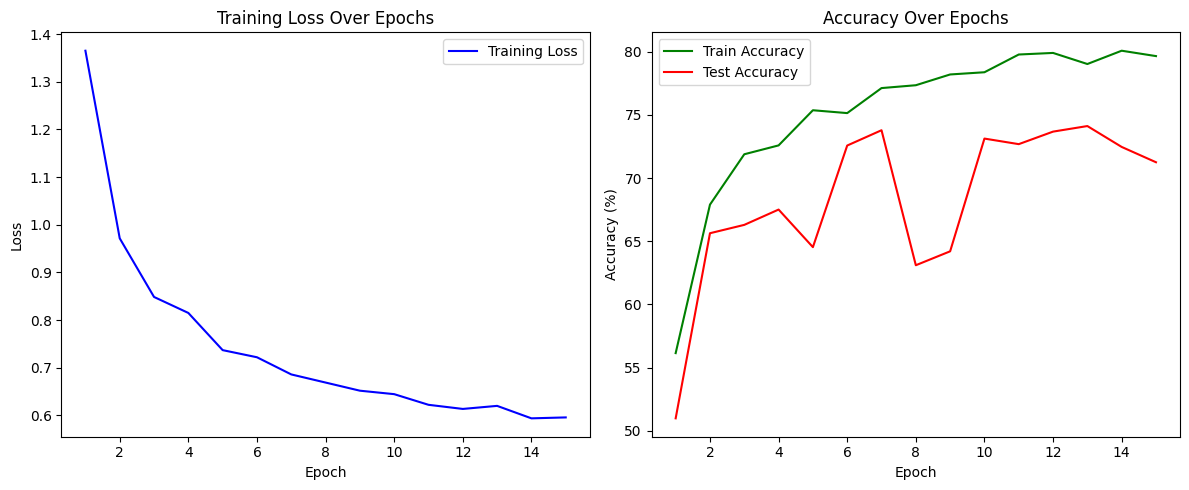

In [ ]:
device = torch.device('cpu')  

classifier = PointNetCls(k=10)
classifier.to(device)  

optimizer = optim.Adam(classifier.parameters(), lr=learning_rate,weight_decay=1e-3)


train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    classifier.train()  
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (points, labels) in enumerate(train_loader):
        points, labels = points.float().to(device), labels.long().to(device)
        points = points.transpose(2, 1)  
        labels = labels.squeeze()  

        optimizer.zero_grad()
        outputs, *_ = classifier(points)  
        loss = F.cross_entropy(outputs, labels)  
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    classifier.eval()  
    correct = 0
    total = 0
    with torch.no_grad():
        for points, labels in test_loader:
            points, labels = points.float().to(device), labels.long().to(device)
            points = points.transpose(2, 1)  
            labels = labels.squeeze()  
            
            outputs, *_ = classifier(points)  
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)

    print(f"Test Accuracy after Epoch [{epoch+1}/{epochs}]: {test_accuracy:.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label="Training Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy", color='green')
plt.plot(range(1, epochs+1), test_accuracies, label="Test Accuracy", color='red')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


## DGCNN

In [2]:
class ModelNet10Dataset(Dataset):
    def __init__(self, d_path, split='train', num_points=1024, txt_file=None, augment=False):
        self.dataset_path = d_path
        self.split = split
        self.num_points = num_points
        self.txt_file = txt_file
        self.mesh_paths = []
        self.labels = []
        self.augment = augment

        self.classes = sorted([cls for cls in os.listdir(d_path) if os.path.isdir(os.path.join(d_path, cls))])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        self.load_mesh_paths_and_labels()

    def load_mesh_paths_and_labels(self):
        if not os.path.exists(self.txt_file):
            raise FileNotFoundError(f"File {self.txt_file} does not exist.")

        with open(self.txt_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                mesh_path = line.strip()
                if not mesh_path:
                    print(f"Skipping empty line.")
                    continue

                class_name = mesh_path.split('/')[0]

                if class_name not in self.class_to_idx:
                    print(f"Skipping unknown class: {class_name}")
                    continue

                label = self.class_to_idx[class_name]

                full_path = os.path.join(self.dataset_path, mesh_path)
                if not os.path.exists(full_path):
                    print(f"Warning: File {full_path} does not exist.")
                    continue

                self.mesh_paths.append(full_path)
                self.labels.append(label)

        if len(self.mesh_paths) == 0:
            raise ValueError(f"No valid data found in {self.txt_file}.")

    def __len__(self):
        return len(self.mesh_paths)

    def __getitem__(self, idx):
        mesh_path = self.mesh_paths[idx]
        pointcloud = self.load_pointcloud(mesh_path)
        label = self.labels[idx]

        pointcloud = self.normalize_point_cloud(pointcloud)

        if self.augment:
            pointcloud = self.augment_data(pointcloud)

        pointcloud = torch.tensor(pointcloud, dtype=torch.float32).transpose(0, 1)
        return pointcloud, torch.tensor(label, dtype=torch.long)

    def load_pointcloud(self, path):
        try:
            mesh = trimesh.load_mesh(path)
            pointcloud, _ = trimesh.sample.sample_surface(mesh, self.num_points)
            return pointcloud
        except Exception as e:
            print(f"Error loading mesh {path}: {e}")
            return np.zeros((self.num_points, 3), dtype=np.float32)

    def normalize_point_cloud(self, points):
        centroid = np.mean(points, axis=0, keepdims=True)
        points = points - centroid
        furthest_distance = np.max(np.sqrt(np.sum(points ** 2, axis=1, keepdims=True)))
        points = points / furthest_distance
        return points

    def augment_data(self, points):
        angles = np.random.rand() * 2 * np.pi
        cos_angles = np.cos(angles)
        sin_angles = np.sin(angles)
        rotation_matrix = np.array([[cos_angles, -sin_angles, 0], [sin_angles, cos_angles, 0], [0, 0, 1]])
        points = np.dot(points, rotation_matrix)
        scale = np.random.rand() * 0.2 + 0.9
        points = points * scale
        translation = np.random.randn(3) * 0.1
        points = points + translation
        return points

In [3]:
d_path = "C:/Users/daneb/.keras/datasets/modelnet_extracted/ModelNet10"
train_txt_file = "C:/Users/daneb/.keras/datasets/modelnet_extracted/ModelNet10/train.txt"
test_txt_file = "C:/Users/daneb/.keras/datasets/modelnet_extracted/ModelNet10/test.txt"

train_dataset_dgcnn = ModelNet10Dataset(d_path, split='train', num_points=1024, txt_file=train_txt_file)
test_dataset_dgcnn = ModelNet10Dataset(d_path, split='test', num_points=1024, txt_file=test_txt_file)

train_loader = DataLoader(train_dataset_dgcnn, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_dgcnn, batch_size=32, shuffle=False)

pointcloud, label = train_dataset_dgcnn[0]
print(pointcloud.shape)  
print(label) 


torch.Size([3, 1024])
tensor(0)


In [13]:
class DGCNN_Classifier(torch.nn.Module):
    def __init__(self, num_classes=10, emb_dims=1024):
        super(DGCNN_Classifier, self).__init__()
        self.dgcnn = DGCNN(emb_dims=emb_dims)
        self.fc1 = torch.nn.Linear(emb_dims, 512)
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.dp1 = torch.nn.Dropout(p=0.5)
        self.fc3 = torch.nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.dgcnn(x)  
        x = x.max(dim=2)[0]  
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dp1(x)
        x = self.fc3(x)
        return x

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DGCNN_Classifier(num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', verbose=True, patience=5, factor=0.2) 

train_losses = []
train_accuracies = []
val_accuracies = []  

for epoch in range(5):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for points, labels in train_loader:
        points, labels = points.to(device), labels.to(device)
        points = points.permute(0, 2, 1)  
        
        optimizer.zero_grad()
        outputs = model(points)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    train_acc = 100.0 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

   
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for points, labels in test_loader:
            points, labels = points.to(device), labels.to(device)
            points = points.permute(0, 2, 1)
            outputs = model(points)
            val_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(test_loader)
    val_acc = 100.0 * correct / total
    val_accuracies.append(val_acc)


    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)

Epoch 1, Loss: 0.4533, Train Accuracy: 86.44%, Validation Accuracy: 63.11%
Epoch 2, Loss: 0.2484, Train Accuracy: 92.21%, Validation Accuracy: 75.88%
Epoch 3, Loss: 0.2201, Train Accuracy: 92.68%, Validation Accuracy: 80.62%
Epoch 4, Loss: 0.2007, Train Accuracy: 93.08%, Validation Accuracy: 87.33%
Epoch 5, Loss: 0.1727, Train Accuracy: 94.04%, Validation Accuracy: 76.10%


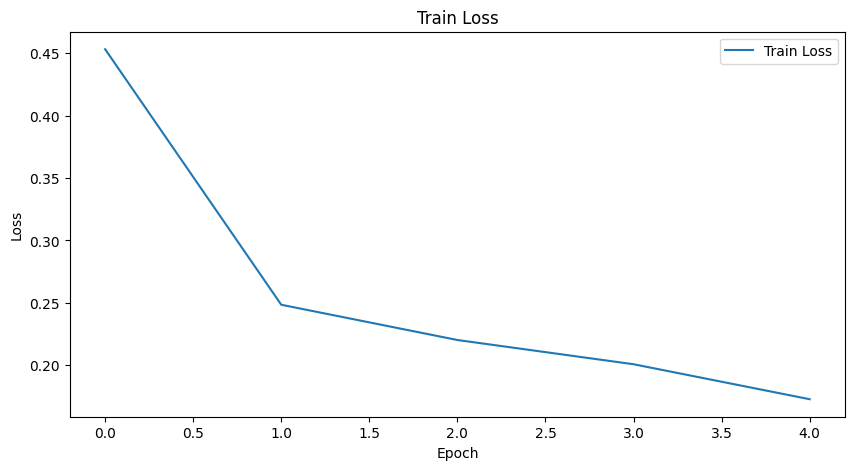

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()
plt.show()

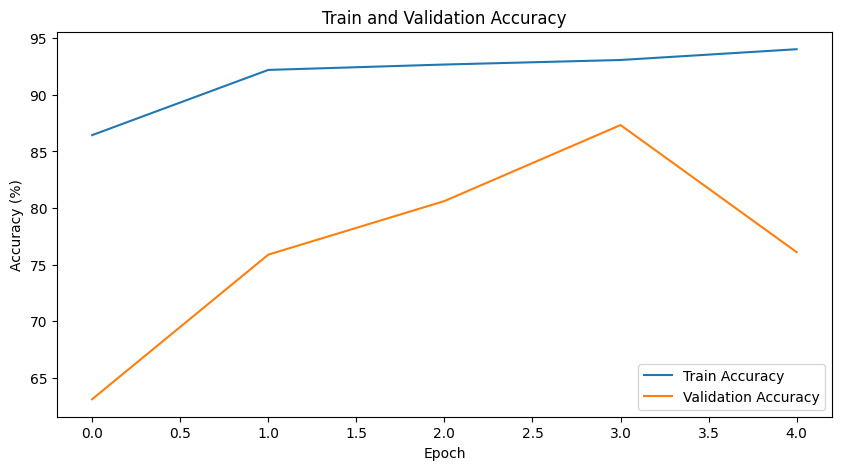

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [17]:
torch.save(model.state_dict(), "dgcnn_model_weights.pth")

## ZARAS, OSSZEGZES
Hasznalt adathalmaz: [ModelNet10 - Princeton](http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip")

Erintentett modszerek:
- SVM
- RandomForest
- PointNet
- DGCNN

| Modszer/modell | Pontossag | Bemenet                          |Runtime|
|----------------|-----------|----------------------------------|--------|
| SVM            |     39.07% (rbf) - 40.07% (linear) - 26.46% (poly) - 29.72% (sigmoid)       | Topologiai/Geometriai leirok     |1.2s|
| RandomForest   |     76.63%      | Topologiai/Geometriai leirok     |0.7s|
| PointNet       |     80.08% (train) - 72.47% (test)      | Point Cloud                      | 29m (15 epoch)|
| DGCNN          |     93.08% (train) - 87.33% (test)| Point Cloud, de graf generalodik | 36m (5 epoch)
